### Task 2

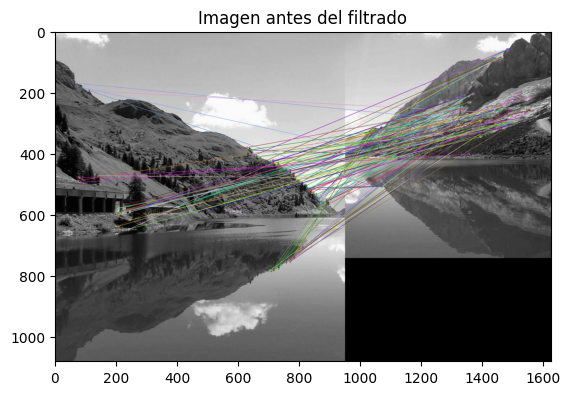

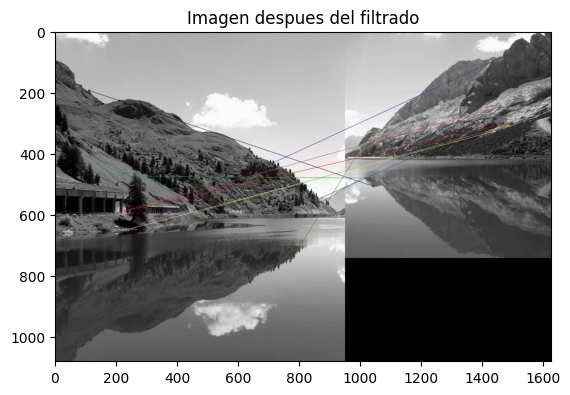

In [21]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

imagen = cv2.imread('./imagenes/paisaje1.jpeg', cv2.IMREAD_GRAYSCALE)
imagen2 = cv2.imread('./imagenes/paisaje2.jpeg', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()

puntos_interes, descriptores = orb.detectAndCompute(imagen, None)
puntos_interes2, descriptores2 = orb.detectAndCompute(imagen2, None)

fuerza_bruta = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = fuerza_bruta.match(descriptores, descriptores2)

imagen_antes_filtrado = cv2.drawMatches(imagen, puntos_interes, imagen2, puntos_interes2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(imagen_antes_filtrado)

plt.title("Imagen antes del filtrado")

plt.show()

matches = sorted(matches, key=lambda x: x.distance)

img3 = cv2.drawMatches(imagen, puntos_interes, imagen2, puntos_interes2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.title("Imagen despues del filtrado")
plt.show()

In [22]:
mejores_matches = matches[:4]

puntos_src = np.array([puntos_interes[m.queryIdx].pt  for m in mejores_matches], dtype=np.float64)
puntos_dst = np.array([puntos_interes2[m.trainIdx].pt for m in mejores_matches], dtype=np.float64)

def normalizar_puntos(puntos):
    media = puntos.mean(axis=0)
    std   = puntos.std()
    if std < 1e-8:
        std = 1.0

    T = np.array([
        [1/std,    0,   -media[0]/std],
        [0,     1/std,  -media[1]/std],
        [0,        0,             1.0]
    ])

    N = puntos.shape[0]
    puntos_h    = np.hstack([puntos, np.ones((N, 1))])
    puntos_norm = (T @ puntos_h.T).T

    return puntos_norm[:, :2], T


def calcular_homografia_dlt(puntos_src, puntos_dst):
    puntos_src = np.array(puntos_src, dtype=np.float64)
    puntos_dst = np.array(puntos_dst, dtype=np.float64)

    assert puntos_src.shape == (4, 2), "Se necesitan exactamente 4 puntos fuente"
    assert puntos_dst.shape == (4, 2), "Se necesitan exactamente 4 puntos destino"

    src_norm, T_src = normalizar_puntos(puntos_src)
    dst_norm, T_dst = normalizar_puntos(puntos_dst)

    A = []
    for i in range(4):
        x,  y  = src_norm[i]
        xp, yp = dst_norm[i]

        A.append([-x, -y, -1,   0,  0,  0,  xp*x, xp*y, xp])
        A.append([ 0,  0,  0,  -x, -y, -1,  yp*x, yp*y, yp])

    A = np.array(A)  

    U, S, Vt = np.linalg.svd(A)
    h      = Vt[-1]
    H_norm = h.reshape(3, 3)

    H = np.linalg.inv(T_dst) @ H_norm @ T_src
    H = H / H[2, 2]

    return H


H = calcular_homografia_dlt(puntos_src, puntos_dst)
print("Matriz de Homografía H:")
print(H)

Matriz de Homografía H:
[[-7.16736773e-01 -5.52654137e-01  4.75131186e+02]
 [-4.15201929e-01 -4.19690209e-01  3.34465230e+02]
 [-1.34415559e-03 -1.22003976e-03  1.00000000e+00]]


In [23]:
def ransac_homografia(matches, puntos_interes, puntos_interes2, umbral, prob_exito):
 
    todos_src = np.array([puntos_interes[m.queryIdx].pt  for m in matches], dtype=np.float64)
    todos_dst = np.array([puntos_interes2[m.trainIdx].pt for m in matches], dtype=np.float64)

    n_matches    = len(matches)
    mejor_H      = None
    mejor_inliers = []
    s = 4          
    e = 0.5        

    
    
    def calcular_N(e, p, s):
        
        denominador = np.log(1 - (1 - e) ** s)
        if denominador == 0:
            return 1
        N = np.log(1 - p) / denominador
        return int(np.ceil(abs(N)))

    N = calcular_N(e, prob_exito, s)
    iteracion = 0


    while iteracion < N:
        iteracion += 1

        
        indices = np.random.choice(n_matches, s, replace=False)
        src_muestra = todos_src[indices]
        dst_muestra = todos_dst[indices]

        
        try:
            H_test = calcular_homografia_dlt(src_muestra, dst_muestra)
        except Exception:
            continue  

        N_pts   = todos_src.shape[0]
        src_h   = np.hstack([todos_src, np.ones((N_pts, 1))])  
        dst_proy = (H_test @ src_h.T).T                        

        
        w = dst_proy[:, 2:3]
        dst_proy_norm = dst_proy[:, :2] / w                    

        
        errores = np.linalg.norm(dst_proy_norm - todos_dst, axis=1)  
        inliers_mask = errores < umbral
        inliers_idx  = np.where(inliers_mask)[0]

        
        if len(inliers_idx) > len(mejor_inliers):
            mejor_inliers = inliers_idx
            mejor_H       = H_test

            
            e_nuevo = 1 - len(inliers_idx) / n_matches
            e       = max(e_nuevo, 0.01)      
            N       = calcular_N(e, prob_exito, s)

    
    src_inliers = todos_src[mejor_inliers]
    dst_inliers = todos_dst[mejor_inliers]

    
    src_norm, T_src = normalizar_puntos(src_inliers)
    dst_norm, T_dst = normalizar_puntos(dst_inliers)

    
    A = []
    for i in range(len(src_inliers)):
        x,  y  = src_norm[i]
        xp, yp = dst_norm[i]
        A.append([-x, -y, -1,   0,  0,  0,  xp*x, xp*y, xp])
        A.append([ 0,  0,  0,  -x, -y, -1,  yp*x, yp*y, yp])

    A = np.array(A)

    U, S, Vt = np.linalg.svd(A)
    h        = Vt[-1]
    H_final  = h.reshape(3, 3)
    H_final  = np.linalg.inv(T_dst) @ H_final @ T_src
    H_final  = H_final / H_final[2, 2]

    return H_final, mejor_inliers



H_ransac, inliers = ransac_homografia(
    matches,
    puntos_interes,
    puntos_interes2,
    umbral=3.0,
    prob_exito=0.99
)

print("\nHomografía RANSAC final:")
print(H_ransac)
print(f"Total inliers: {len(inliers)}/{len(matches)}")

/var/folders/7v/fnx495qx7zqd77glm78ts93r0000gn/T/ipykernel_12066/270863058.py:46: RuntimeWarning: divide by zero encountered in divide
  dst_proy_norm = dst_proy[:, :2] / w
/var/folders/7v/fnx495qx7zqd77glm78ts93r0000gn/T/ipykernel_12066/270863058.py:46: RuntimeWarning: invalid value encountered in divide
  dst_proy_norm = dst_proy[:, :2] / w



Homografía RANSAC final:
[[ 6.19581483e-02 -8.24581661e-01  3.82338472e+02]
 [ 3.15976794e-02 -5.22414590e-01  2.48854802e+02]
 [ 1.46232408e-04 -2.13107445e-03  1.00000000e+00]]
Total inliers: 10/122


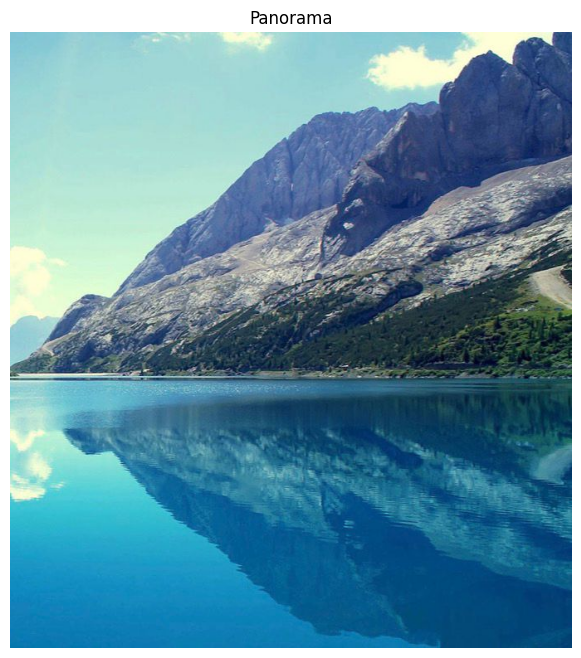

In [24]:

imagen_color  = cv2.imread('./imagenes/paisaje1.jpeg')
imagen_color  = cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB)
imagen2_color = cv2.imread('./imagenes/paisaje2.jpeg')
imagen2_color = cv2.cvtColor(imagen2_color, cv2.COLOR_BGR2RGB)

h1, w1 = imagen_color.shape[:2]
h2, w2 = imagen2_color.shape[:2]



esquinas_img1 = np.array([
    [0,  0],
    [w1, 0],
    [w1, h1],
    [0,  h1]
], dtype=np.float64)


esquinas_h   = np.hstack([esquinas_img1, np.ones((4, 1))])
esquinas_proy = (H_ransac @ esquinas_h.T).T
esquinas_proy = esquinas_proy[:, :2] / esquinas_proy[:, 2:3]


todas_esquinas = np.vstack([
    esquinas_proy,
    [[0, 0], [w2, 0], [w2, h2], [0, h2]]
])

x_min, y_min = todas_esquinas.min(axis=0).astype(int)
x_max, y_max = todas_esquinas.max(axis=0).astype(int)

ancho_canvas = x_max - x_min
alto_canvas  = y_max - y_min


T_offset = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0,      1]
], dtype=np.float64)

H_final_offset = T_offset @ H_ransac

canvas = cv2.warpPerspective(imagen_color, H_final_offset, (ancho_canvas, alto_canvas))

canvas[-y_min:h2 + (-y_min), -x_min:w2 + (-x_min)] = imagen2_color

plt.figure(figsize=(18, 8))
plt.title("Panorama")
plt.imshow(canvas)
plt.axis('off')
plt.show()